In [55]:
import pandas as pd
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')


from utils import *
main_path = r'D:\Git_project\Jupyter_Projects\Smart_house\data\device_log_join_device_type.csv'

In [56]:
def save_models(lst, filename):
    filename = '{}.sav'.format(filename)
    pk.dump(lst, open(filename, 'wb'))
    print('save models', filename)

In [57]:
data = pd.read_csv(main_path, encoding = "cp1251", sep=',',  engine='python')
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

# Словарь для того чтобы смотреть какая комната
device_name_dict = data[['device_name','desc']].drop_duplicates().set_index(keys='device_name').to_dict()['desc']
device_name_dict = {i: '{}-{}'.format(i,j) for i,j in zip(list(device_name_dict.keys()),list(device_name_dict.values()))}
device_name_dict

{'HUMSENS1': 'HUMSENS1-Влажность в котельной',
 'TEMPSENS2': 'TEMPSENS2-Температура под крыльцом',
 'TEMPSENS1': 'TEMPSENS1-Температура рядом с котлом',
 'PRESSENS1': 'PRESSENS1-Давление наружного воздуха',
 'GAZDTCT1': 'GAZDTCT1-Газ рядом с котлом',
 'HUMSENS2': 'HUMSENS2-Влажность юго-восточная комната',
 'HUMSENS3': 'HUMSENS3-Влажность юго-западная комната',
 'HUMSENS4': 'HUMSENS4-Влажность северо-восточная комната',
 'HUMSENS5': 'HUMSENS5-Влажность северо-западная комната',
 'MOTSENS1': 'MOTSENS1-Присутствие юго-западная комната',
 'TEMPSENS3': 'TEMPSENS3-Температура юго-восточная комната',
 'TEMPSENS4': 'TEMPSENS4-Температура юго-западная комната',
 'TEMPSENS5': 'TEMPSENS5-Температура северо-восточная комната',
 'TEMPSENS6': 'TEMPSENS6-Температура северо-западная комната',
 'MOTSENS10': 'MOTSENS10-Движение тамбур',
 'HUMSENS10': 'HUMSENS10-Влажность тамбур',
 'HUMSENS11': 'HUMSENS11-Влажность столовая',
 'MOTSENS9': 'MOTSENS9-Движение столовая',
 'TEMPSENS11': 'TEMPSENS11-Температ

# Подготовка данных #
Перевод в формат среднего для каждого дня и заполнение пустых значений 

In [58]:
data['id_sp'] = data['id'].apply(lambda x: x.split(' ')[0])
clm = ['un','id','device_name','value']
data_pivot = data[clm].pivot('un','device_name','value')
data_pivot_date = data_pivot.join(data[['un','id','id_sp']].set_index('un'))

In [59]:
DROP_CLM = [ 'SRN1', 'TEMPSENS2', 'TEMPSENS11', 'TEMPSENS12','HUMSENS10','HUMSENS11','MOTSENS10', 'MOTSENS9']
CORR_COEFF = 0.7
data_corr, data_pivot = sensor_data_mean('id_sp', data_pivot_date=data_pivot_date, fillna='bfill', DROP_CLM=DROP_CLM)
data_corr.to_csv(r'sensor_data_vis_corr.csv', index=False)
corr = data_corr.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
corr['value'] =corr['value'].abs()
# фильтруем корреляцию
corr = corr[(corr['value']>=CORR_COEFF) & (corr['value']!=1.0)]

corr_data_frame = corr.pivot('y','x')['value']
corr_data_frame.columns
data_pivot.to_csv(r'sensor_data_vis.csv', index=True, )

In [43]:
data_corr

,GAZDTCT1,HUMSENS1,HUMSENS2,HUMSENS3,HUMSENS4,HUMSENS5,MOTSENS1,PRESSENS1,TEMPSENS1,TEMPSENS3,TEMPSENS4,TEMPSENS5,TEMPSENS6
0,256.975610,57.074157,49.391892,43.178947,44.235714,46.263415,0.743590,741.195000,15.775581,17.036667,19.545161,17.372222,16.569697
1,282.968627,54.709350,52.057609,45.332222,46.042453,48.367347,0.131313,741.633261,16.159608,17.123944,19.486076,17.393902,16.484810
2,276.519531,49.935526,52.319101,45.547253,47.462376,49.125743,0.000000,745.956705,17.208000,17.127536,19.512658,17.122500,16.363750
3,259.650794,48.089855,49.291304,43.437363,44.943299,46.338462,0.000000,748.624556,17.045205,17.063768,19.350633,17.134146,16.403704
4,255.841270,47.161972,49.138043,42.902198,44.705660,46.260204,0.000000,748.008333,16.980000,17.027941,19.500000,17.006098,16.248780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,NaN,NaN,37.775000,33.146667,32.124272,37.357895,0.236842,NaN,NaN,25.783824,28.106494,26.346383,25.230000
824,NaN,NaN,45.506452,40.059574,38.462727,43.968627,0.364706,NaN,NaN,25.040000,27.516867,25.906122,24.760714
825,NaN,NaN,46.121875,40.693478,39.497196,44.827273,0.256250,NaN,NaN,24.314286,26.871605,25.212757,24.028395
826,NaN,NaN,43.489247,38.073404,36.936111,42.283000,0.367568,NaN,NaN,24.062319,26.466667,24.779839,23.571084


## Предсказание происходит в зависимости от какого момента и насколько признаков назад надо взять
пример мы хотим предсказывать на 1 шагов вперед беря 7 шагов назад

In [44]:
def create_data_for_pred(data, corr_data, weekday=True, pred_d=1, lag=7, another=True, CORR_COEFF=None, time=False):
    data = data.copy()
    data_frames = []
    for d in data.columns:
        print(d)
        clm = [d]
        if another and d in corr_data.columns:
            clm = clm + list(corr_data[d].dropna().to_dict().keys())
            data_feature = data[clm]
        else:
            data_feature = data[clm]
        for l in range(pred_d,lag+1):
            data_feature['lag_{}'.format(l)] = data_feature[d].shift(l)
        if weekday:
            data_feature.index = pd.to_datetime(data_feature.index)
            seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
            month_to_season = dict(zip(range(1,13), seasons))
            data_feature['season'] = data_feature.index.month.map(month_to_season) 
            data_feature['weekday'] = data_feature.index.weekday
            data_feature['is_weekend'] = data_feature.weekday.isin([5,6])*1
        if CORR_COEFF:
            corr = data_feature.corr()
            corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
            corr.columns = ['x', 'y', 'value']
            corr['value'] =corr['value'].abs()
            # фильтруем корреляцию
            corr = corr[(corr['value']>=CORR_COEFF) & (corr['value']!=1.0)]
            corr_data_frame = corr.pivot('y','x')['value']
#             print(corr)
        if time:
            data_feature['time'] = data_feature.index
        data_feature = data_feature.dropna().reset_index(drop=True)
        data_frames.append(data_feature)
    return data_frames



Для газа до 484 значения

6 индекс это датчик движения

In [60]:
for i in data_pivot.columns:
    if 'MOT' in i:
        data_pivot[i] = data_pivot[i].apply(lambda x: 0 if x <= 0 else 1)
prepared_data = create_data_for_pred(data_pivot[:], corr_data_frame,pred_d=1, lag=7, time=False)
prepared_data[0]

GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6


,GAZDTCT1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,season,weekday,is_weekend
0,349.959514,315.245968,251.523810,255.841270,259.650794,276.519531,282.968627,256.975610,1,6,1
1,333.354839,349.959514,315.245968,251.523810,255.841270,259.650794,276.519531,282.968627,1,0,0
2,350.219608,333.354839,349.959514,315.245968,251.523810,255.841270,259.650794,276.519531,1,1,0
3,333.000000,350.219608,333.354839,349.959514,315.245968,251.523810,255.841270,259.650794,1,2,0
4,380.344828,333.000000,350.219608,333.354839,349.959514,315.245968,251.523810,255.841270,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...
827,1.109890,1.027027,1.087912,1.035294,1.111111,1.621429,1.381295,1.661538,2,2,0
828,1.163793,1.109890,1.027027,1.087912,1.035294,1.111111,1.621429,1.381295,2,3,0
829,1.142857,1.163793,1.109890,1.027027,1.087912,1.035294,1.111111,1.621429,2,4,0
830,1.076923,1.142857,1.163793,1.109890,1.027027,1.087912,1.035294,1.111111,2,5,1


In [46]:
data_for_model = prepared_data[1]
y_clmn = data_for_model.columns[0]
print(device_name_dict[y_clmn])
y = data_for_model[y_clmn]
print('Удаленные столбцы',[y_clmn]+DROP_CLM)
X = data_for_model.drop([y_clmn], axis=1)

HUMSENS1-Влажность в котельной
Удаленные столбцы ['HUMSENS1', 'SRN1', 'TEMPSENS2', 'TEMPSENS11', 'TEMPSENS12', 'HUMSENS10', 'HUMSENS11', 'MOTSENS10', 'MOTSENS9']


# Поиск лучшей модели для детекции движения #

Идеи взять значения, которые вещественные числа и сделать y от 0 до 1 

In [61]:
def get_predict_all(prepared_data, device_name_dict, tscv, scale=False, plot=True):
    lst_models = []

    scaler = StandardScaler()
    scaler_1 = StandardScaler()
    for data_p in prepared_data:
        lr = LinearRegression()
        data_for_model = data_p
        y_clmn = data_for_model.columns[0]
        name_clm = device_name_dict[y_clmn]
        y = data_for_model[y_clmn]
        X = data_for_model.drop([y_clmn], axis=1)
        # reserve 30% of data for testing
        X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
        colmn = X_test.columns
        X_train_interval = X_train
        if scale:
            scaler_1.fit(X_train)
            scaler_1.transform(X_train)
            X_train = scaler.fit_transform(X_train)

            X_test = scaler.transform(X_test)
        # machine learning in two lines
        lr.fit(X_train, y_train)
        prediction = lr.predict(X_test)

        error = mean_absolute_percentage_error(prediction, y_test)
        print("Mean absolute percentage error {} {}".format(round(error, 2), y_clmn))
        lst_models.append(
            {'model': lr, 'error': round(error, 2), 'name': y_clmn, 'full_name': name_clm, 'X_test': X_test,
             'columns': colmn, 'scaler': scaler_1})
        # %%
    if plot:
        plotModelResults(lr, y_train, y_test, tscv, X_train=X_train, X_test=X_test, plot_intervals=True,
                         title=name_clm)
        plotCoefficients(lr, X_train_interval)
    return lst_models

In [62]:
data_pivot

,GAZDTCT1,HUMSENS1,HUMSENS2,HUMSENS3,HUMSENS4,HUMSENS5,MOTSENS1,PRESSENS1,TEMPSENS1,TEMPSENS3,TEMPSENS4,TEMPSENS5,TEMPSENS6
id_sp,,,,,,,,,,,,,
2018-01-07,256.975610,57.074157,49.391892,43.178947,44.235714,46.263415,1,741.195000,15.775581,17.036667,19.545161,17.372222,16.569697
2018-01-08,282.968627,54.709350,49.391892,43.178947,44.235714,46.263415,1,741.633261,16.159608,17.036667,19.545161,17.372222,16.569697
2018-01-09,276.519531,49.935526,49.391892,43.178947,44.235714,46.263415,1,745.956705,17.208000,17.036667,19.545161,17.372222,16.569697
2018-01-10,259.650794,48.089855,49.391892,43.178947,44.235714,46.263415,1,748.624556,17.045205,17.036667,19.545161,17.372222,16.569697
2018-01-11,255.841270,47.161972,49.391892,43.178947,44.235714,46.263415,1,748.008333,16.980000,17.036667,19.545161,17.372222,16.569697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-22,1.109890,45.233784,37.775000,33.146667,32.124272,37.357895,1,741.400899,18.922535,25.783824,28.106494,26.346383,25.230000
2020-04-23,1.163793,44.066667,45.506452,40.059574,38.462727,43.968627,1,738.986526,18.948052,25.040000,27.516867,25.906122,24.760714
2020-04-24,1.142857,44.412987,46.121875,40.693478,39.497196,44.827273,1,734.297500,18.921519,24.314286,26.871605,25.212757,24.028395


# Создание моделей Влажность и Температура #

GAZDTCT1
Index(['GAZDTCT1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS1
Index(['HUMSENS1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS2
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS3
Index(['HUMSENS3', 'HUMSENS2', 'HUMSENS4', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS4
Index(['HUMSENS4', 'HUMSENS2', 'HUMSENS3', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS5
Index(['HUMSENS5', 'HUMSENS2', 'HUMSE

      dtype='object')
Mean absolute percentage error 1.98 HUMSENS4
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 1.59 HUMSENS5
Index(['lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 194.37 MOTSENS1
Index(['lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 0.68 PRESSENS1
Index(['lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 3.87 TEMPSENS1
Index(['TEMPSENS4', 'TEMPSENS5', 'TEMPSENS6', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')

Mean absolute percentage error 218.02 MOTSENS1
Index(['lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday',
       'is_weekend'],
      dtype='object')
Mean absolute percentage error 0.82 PRESSENS1
Index(['lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday',
       'is_weekend'],
      dtype='object')
Mean absolute percentage error 4.3 TEMPSENS1
Index(['TEMPSENS4', 'TEMPSENS5', 'TEMPSENS6', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 1.96 TEMPSENS3
Index(['TEMPSENS3', 'TEMPSENS5', 'TEMPSENS6', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 2.76 TEMPSENS4
Index(['TEMPSENS3', 'TEMPSENS4', 'TEMPSENS6', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
Mean absolute percentage error 0.86 TEMPSENS5
Index(['TEMPSENS3', 'T

GAZDTCT1
Index(['GAZDTCT1', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'], dtype='object')
HUMSENS1
Index(['HUMSENS1', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'], dtype='object')
HUMSENS2
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'HUMSENS5', 'lag_7', 'lag_8',
       'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS3
Index(['HUMSENS3', 'HUMSENS2', 'HUMSENS4', 'HUMSENS5', 'lag_7', 'lag_8',
       'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS4
Index(['HUMSENS4', 'HUMSENS2', 'HUMSENS3', 'HUMSENS5', 'lag_7', 'lag_8',
       'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS5
Index(['HUMSENS5', 'HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'lag_7', 'lag_8',
       'season', 'weekday', 'is_weekend'],
      dtype='object')
MOTSENS1
Index(['MOTSENS1', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'], dtype='object')
PRESSENS1
Index(['PRESSENS1', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'], dtype='object')
TEMPSENS1
Index(['

'\n5.248894027224336\n1.9089025761526817\n2.3427459049919044\n2.0952195237613007\n1.6446007034183245\n0.45402509902066474\n2.543218707716167\n1.8235946682517379\n2.2979169189579647\n0.9010269876446027\n1.135298154736542'

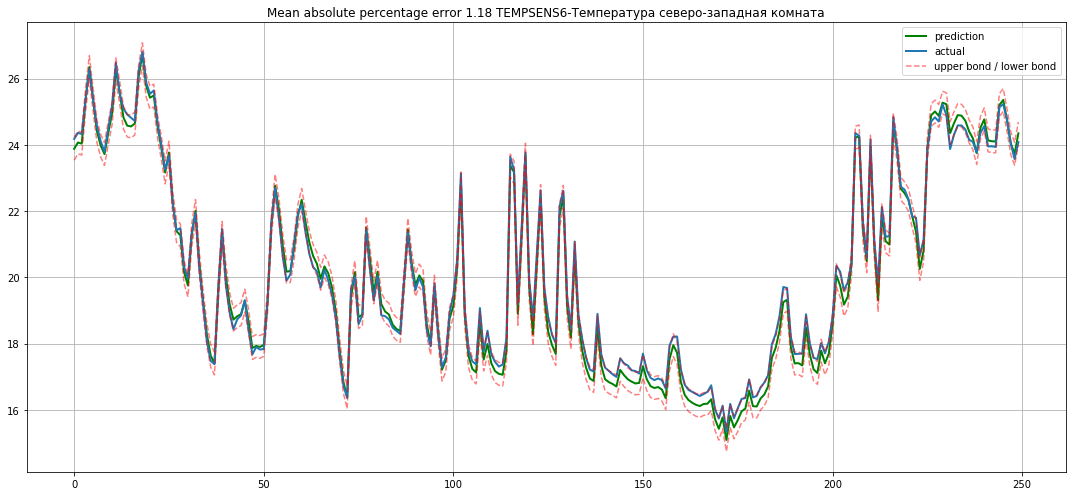

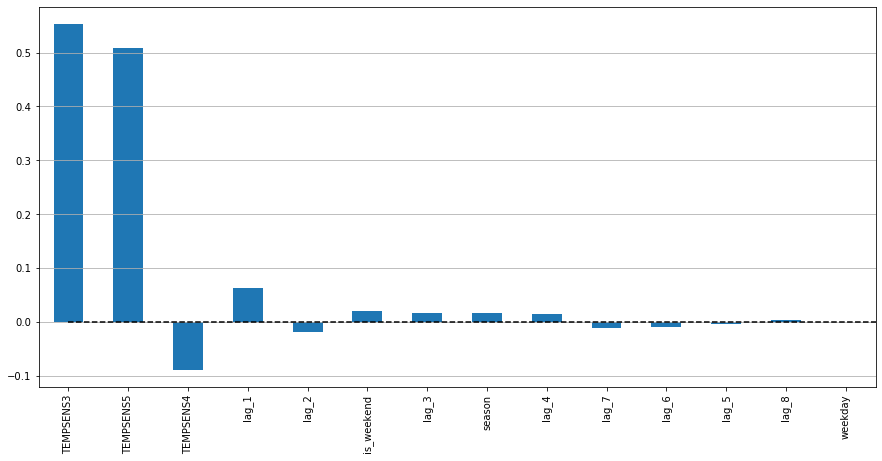

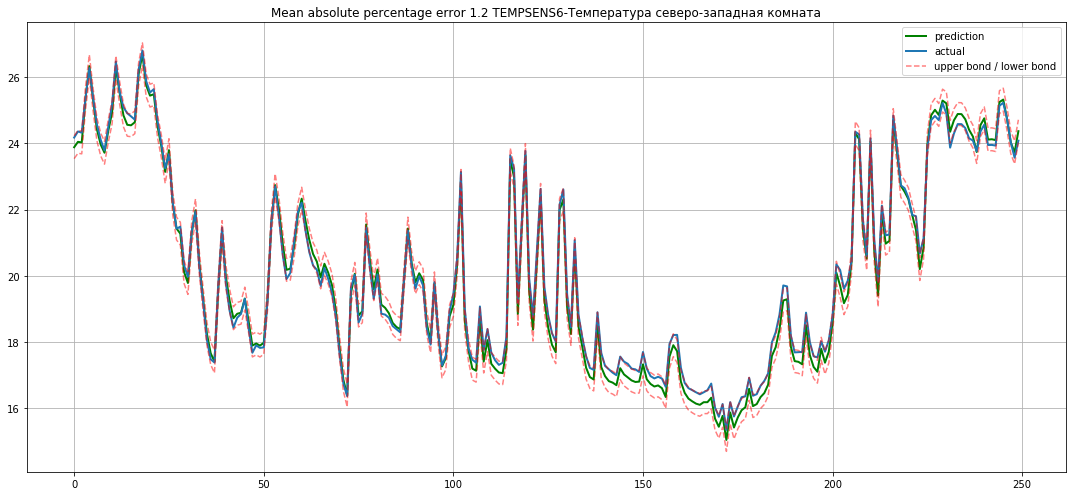

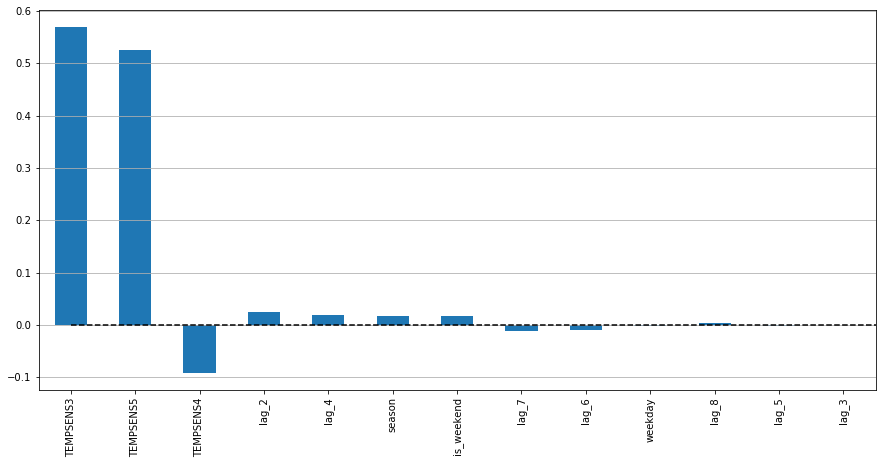

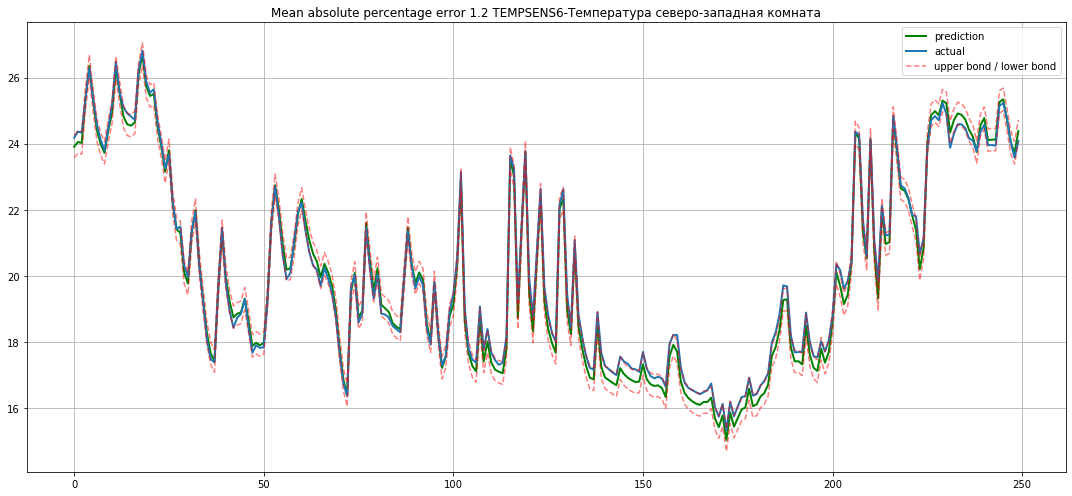

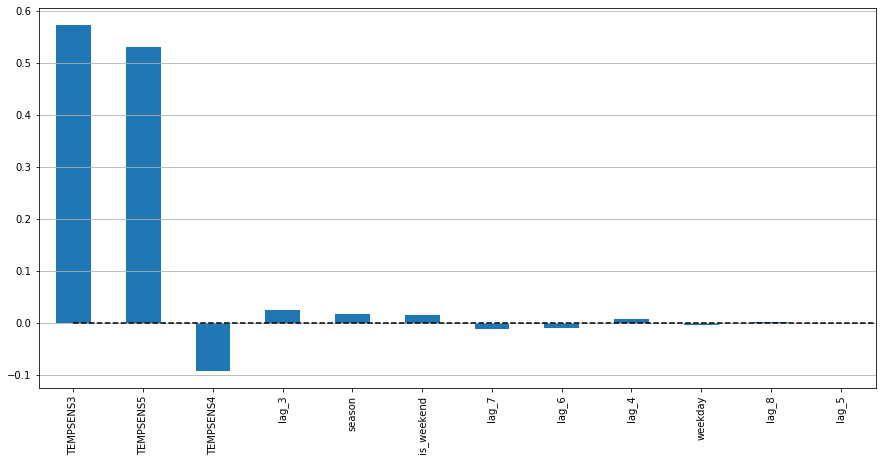

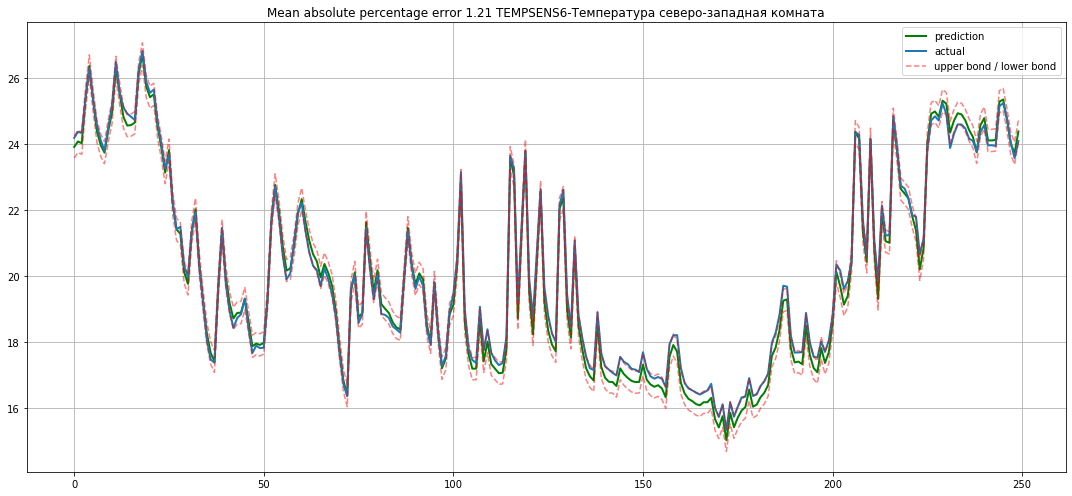

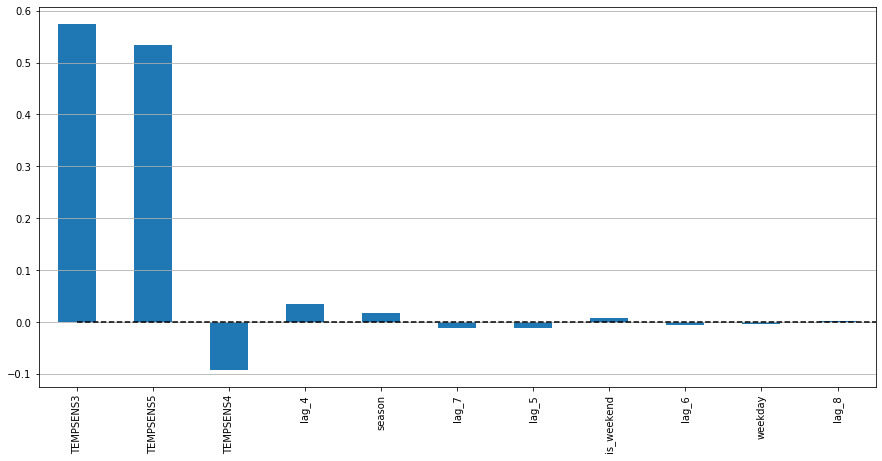

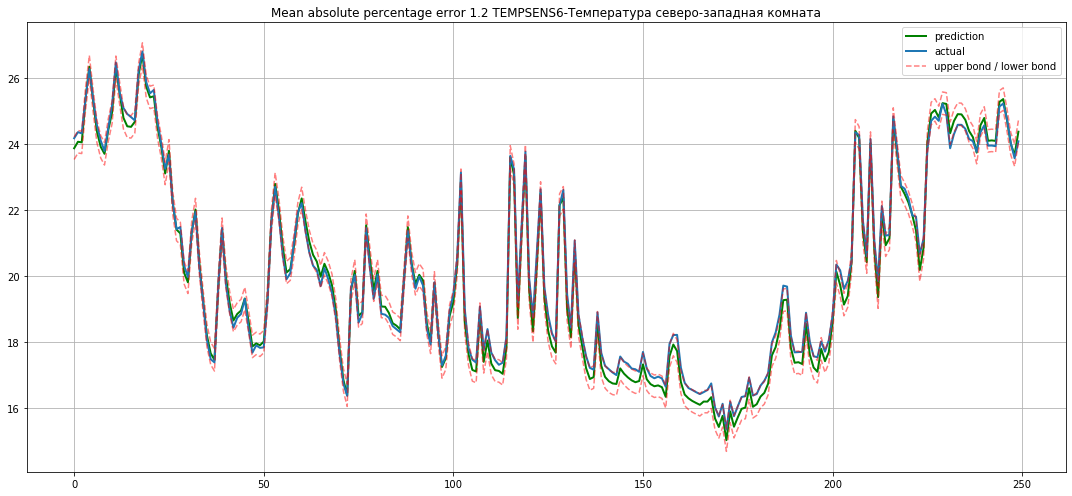

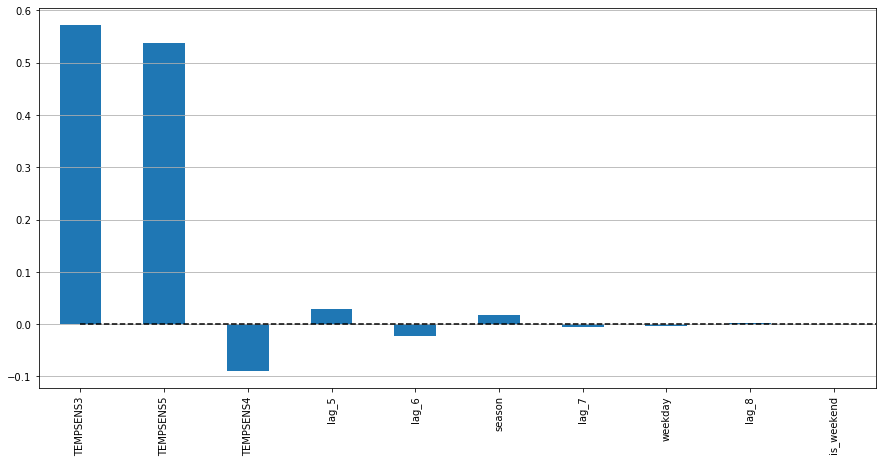

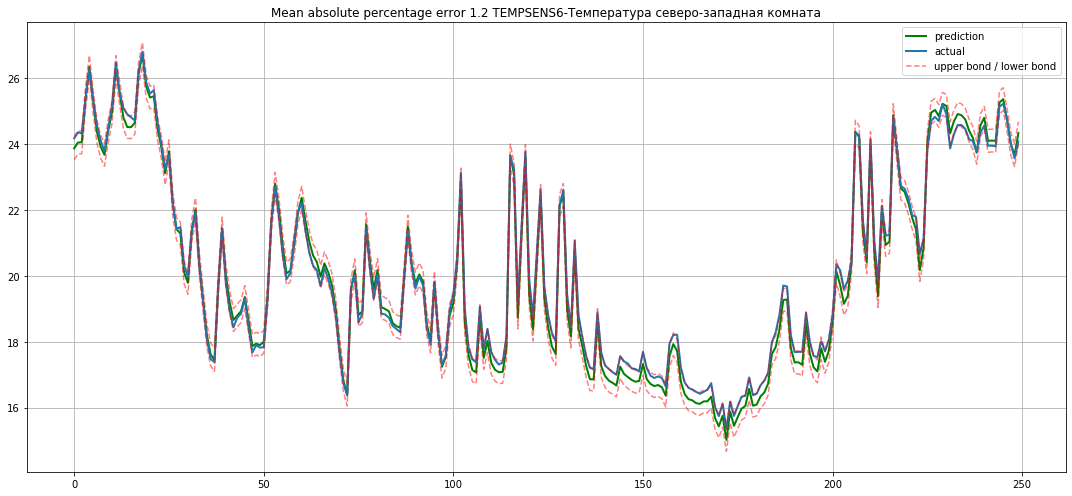

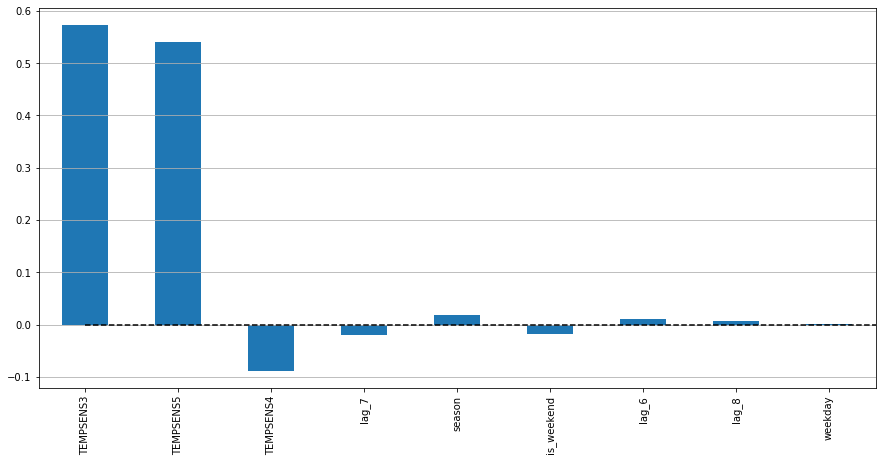

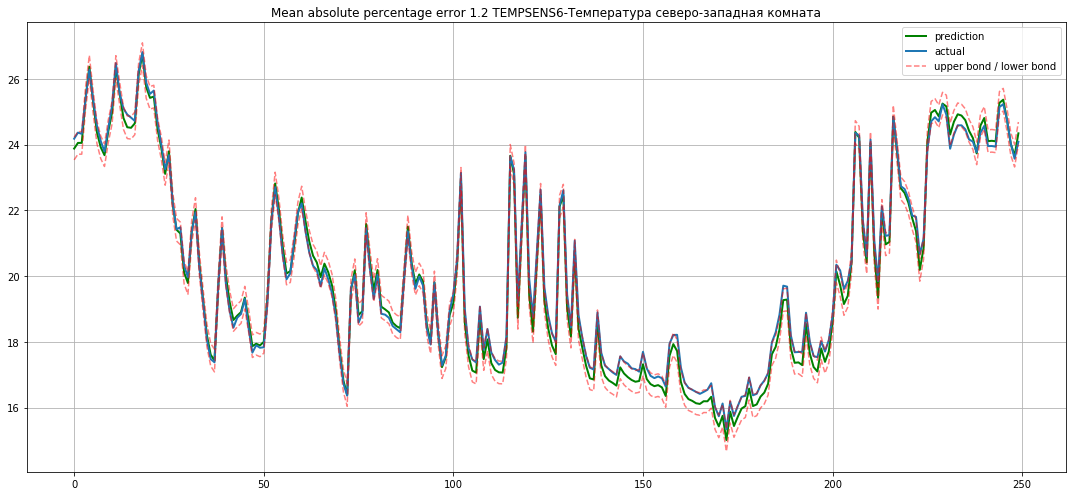

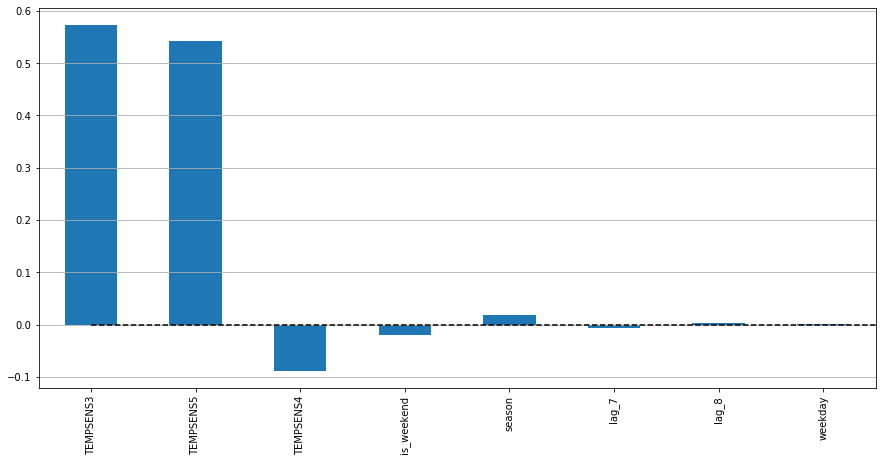

In [61]:
# plt.ioff()
num_pred = 8
lag_back = 8
lst_pred_models = []
for i in range(1,num_pred):
    prepared_data = create_data_for_pred(data_pivot, corr_data_frame,pred_d=i, lag=lag_back, time=False)
    models = get_predict_all(prepared_data, device_name_dict, tscv, scale=False)
    lst_pred_models.append(models)
lst_pred_models = list(zip(* lst_pred_models))
"""
5.248894027224336
1.9089025761526817
2.3427459049919044
2.0952195237613007
1.6446007034183245
0.45402509902066474
2.543218707716167
1.8235946682517379
2.2979169189579647
0.9010269876446027
1.135298154736542"""


# Сохранение модели #

In [63]:
names = """GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6""".split('\n')
for index, n in enumerate(names):
    if n =='GAZDTCT1' or n =='MOTSENS1':
        continue
    else:
        save_models(list(lst_pred_models[index]), '{}-pred_{}'.format(n, lag_back))
        

save models HUMSENS1-pred_8.sav
save models HUMSENS2-pred_8.sav
save models HUMSENS3-pred_8.sav
save models HUMSENS4-pred_8.sav
save models HUMSENS5-pred_8.sav
save models PRESSENS1-pred_8.sav
save models TEMPSENS1-pred_8.sav
save models TEMPSENS3-pred_8.sav
save models TEMPSENS4-pred_8.sav
save models TEMPSENS5-pred_8.sav
save models TEMPSENS6-pred_8.sav


In [50]:
data_sensor = dict(
    ('lag_{}'.format(i), create_data_for_pred(data_pivot, corr_data_frame, pred_d=i, lag=8, time=False)) for i in
    range(1, 8))

GAZDTCT1
Index(['GAZDTCT1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS1
Index(['HUMSENS1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS2
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS3
Index(['HUMSENS3', 'HUMSENS2', 'HUMSENS4', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS4
Index(['HUMSENS4', 'HUMSENS2', 'HUMSENS3', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS5
Index(['HUMSENS5', 'HUMSENS2', 'HUMSE

      dtype='object')
HUMSENS2
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'HUMSENS5', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS3
Index(['HUMSENS3', 'HUMSENS2', 'HUMSENS4', 'HUMSENS5', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS4
Index(['HUMSENS4', 'HUMSENS2', 'HUMSENS3', 'HUMSENS5', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS5
Index(['HUMSENS5', 'HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
MOTSENS1
Index(['MOTSENS1', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday',
       'is_weekend'],
      dtype='object')
PRESSENS1
Index(['PRESSENS1', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday',
       'is_weekend'],
      dtype='object')
TEMPSENS1
Index(['TEMPSENS1', 'lag_5', 'lag_6', 'lag_7', '

In [38]:
data_sensor['lag_1'][1]

,HUMSENS1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,season,weekday,is_weekend,time
0,45.850685,45.258904,44.958333,45.755405,47.161972,48.089855,49.935526,54.709350,57.074157,1,0,0,2018-01-15
1,44.065278,45.850685,45.258904,44.958333,45.755405,47.161972,48.089855,49.935526,54.709350,1,1,0,2018-01-16
2,42.780000,44.065278,45.850685,45.258904,44.958333,45.755405,47.161972,48.089855,49.935526,1,2,0,2018-01-17
3,42.675758,42.780000,44.065278,45.850685,45.258904,44.958333,45.755405,47.161972,48.089855,1,5,1,2018-01-20
4,45.927397,42.675758,42.780000,44.065278,45.850685,45.258904,44.958333,45.755405,47.161972,1,6,1,2018-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,45.233784,47.489610,48.938961,49.506944,50.325333,50.512987,48.147368,47.913699,47.339744,2,2,0,2020-04-22
827,44.066667,45.233784,47.489610,48.938961,49.506944,50.325333,50.512987,48.147368,47.913699,2,3,0,2020-04-23
828,44.412987,44.066667,45.233784,47.489610,48.938961,49.506944,50.325333,50.512987,48.147368,2,4,0,2020-04-24
829,44.449351,44.412987,44.066667,45.233784,47.489610,48.938961,49.506944,50.325333,50.512987,2,5,1,2020-04-25


In [62]:
m = lst_pred_models[1][0]
print(m)
model = m['model']
X_test = m['X_test']

model.predict(X_test)

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'error': 3.88, 'name': 'HUMSENS1', 'full_name': 'HUMSENS1-Влажность в котельной', 'X_test':          lag_1      lag_2      lag_3      lag_4      lag_5      lag_6  \
581  89.675342  88.876000  84.504054  81.374359  86.470270  89.593243   
582  91.500000  89.675342  88.876000  84.504054  81.374359  86.470270   
583  91.723288  91.500000  89.675342  88.876000  84.504054  81.374359   
584  89.253333  91.723288  91.500000  89.675342  88.876000  84.504054   
585  81.480519  89.253333  91.723288  91.500000  89.675342  88.876000   
..         ...        ...        ...        ...        ...        ...   
826  47.489610  48.938961  49.506944  50.325333  50.512987  48.147368   
827  45.233784  47.489610  48.938961  49.506944  50.325333  50.512987   
828  44.066667  45.233784  47.489610  48.938961  49.506944  50.325333   
829  44.412987  44.066667  45.233784  47.489610  48.938961  49.506944   
830  44.449351

array([88.56939427, 90.66169624, 89.97607818, 88.65106499, 81.75811475,
       83.30436304, 83.70088571, 86.36832938, 80.49413973, 81.00260645,
       83.04714309, 83.62485924, 80.91795389, 86.55537217, 84.68296498,
       86.0063061 , 88.35238297, 88.00442491, 82.34215711, 81.69499494,
       84.50053832, 83.2275156 , 83.16994058, 82.95027624, 81.9846074 ,
       78.55640881, 71.05992256, 76.79503352, 71.13212227, 71.68854549,
       71.96270745, 67.81190762, 59.12622326, 60.1917554 , 61.28844902,
       59.62766332, 60.1698793 , 59.89272903, 60.88639051, 55.80652056,
       57.4179278 , 65.35132827, 67.48077978, 64.44651805, 69.60783909,
       68.57690572, 62.23264948, 60.442618  , 58.01482884, 55.85670971,
       56.53211113, 57.7583222 , 58.87428274, 56.95242759, 58.42232964,
       60.72887864, 60.29435976, 55.08083336, 60.65891409, 63.06221884,
       65.48261899, 62.38655459, 65.86735893, 63.88933718, 65.35349053,
       63.50845955, 62.80957101, 60.98687336, 65.80629099, 56.57

In [14]:
# Сохранение модели для Движения #

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'error': 4.88,
 'name': 'TEMPSENS1',
 'full_name': 'TEMPSENS1-Температура рядом с котлом',
 'columns': Index(['lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'], dtype='object')}

# Сохранение модели для Движения #

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


num_pred = 8
lag_back = 8
lst_pred_models = []
for i in range(1,num_pred):

    prepared_data = create_data_for_pred(data_pivot[:], corr_data_frame,pred_d=i, lag=lag_back, time=False)
    print(prepared_data[6])
    data_for_model = prepared_data[6]
    y_clmn = data_for_model.columns[0]
    print(device_name_dict[y_clmn])
    y = data_for_model[y_clmn]
    print('Удаленные столбцы',[y_clmn]+DROP_CLM)
    X = data_for_model.drop([y_clmn], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
    X_train.head(10)

    target_names = ['не было', 'был']


    lr = GaussianNB()

    lr.fit(X_train, y_train)
    lst_pred_models
    prediction = lr.predict(X_test)
    confusion_matrix(y_test, prediction)
    report = classification_report(y_test, prediction, target_names=target_names)
    print(report)
    print()
    lst_pred_models.append({'model':lr, 'name':'MOTSENS1', 'f1': report[report.find('accuracy'):report.find('accuracy')+40].split(' ')[-2]})
save_models(lst_pred_models, '{}-pred_{}'.format('MOTSENS1', lag_back))


GAZDTCT1
Index(['GAZDTCT1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS1
Index(['HUMSENS1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS2
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS3
Index(['HUMSENS3', 'HUMSENS2', 'HUMSENS4', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS4
Index(['HUMSENS4', 'HUMSENS2', 'HUMSENS3', 'HUMSENS5', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season',
       'weekday', 'is_weekend'],
      dtype='object')
HUMSENS5
Index(['HUMSENS5', 'HUMSENS2', 'HUMSE

Index(['GAZDTCT1', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS1
Index(['HUMSENS1', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS2
Index(['HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'HUMSENS5', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS3
Index(['HUMSENS3', 'HUMSENS2', 'HUMSENS4', 'HUMSENS5', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS4
Index(['HUMSENS4', 'HUMSENS2', 'HUMSENS3', 'HUMSENS5', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
      dtype='object')
HUMSENS5
Index(['HUMSENS5', 'HUMSENS2', 'HUMSENS3', 'HUMSENS4', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'season', 'weekday', 'is_weekend'],
     

      dtype='object')
     MOTSENS1  lag_5  lag_6  lag_7  lag_8  season  weekday  is_weekend
0           1    1.0    1.0    1.0    1.0       1        0           0
1           1    1.0    1.0    1.0    1.0       1        1           0
2           1    1.0    1.0    1.0    1.0       1        2           0
3           1    1.0    1.0    1.0    1.0       1        5           1
4           1    1.0    1.0    1.0    1.0       1        6           1
..        ...    ...    ...    ...    ...     ...      ...         ...
826         1    1.0    1.0    1.0    1.0       2        2           0
827         1    1.0    1.0    1.0    1.0       2        3           0
828         1    1.0    1.0    1.0    1.0       2        4           0
829         1    1.0    1.0    1.0    1.0       2        5           1
830         1    1.0    1.0    1.0    1.0       2        6           1

[831 rows x 8 columns]
MOTSENS1-Присутствие юго-западная комната
Удаленные столбцы ['MOTSENS1', 'SRN1', 'TEMPSENS2', 'TEMPSEN

In [14]:
lst_pred_models[0]['model']

GaussianNB(priors=None, var_smoothing=1e-09)

# Сохранение Газа #

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


num_pred = 8
lag_back = 8
lst_pred_models = []
for i in range(1,num_pred):

    prepared_data = create_data_for_pred(data_pivot[:484], corr_data_frame,pred_d=i, lag=lag_back, time=False)
    data_for_model = prepared_data[0]
    y_clmn = data_for_model.columns[0]
    y = data_for_model[y_clmn]
    X = data_for_model.drop([y_clmn], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
    X_train.head(10)



    lr = LinearRegression()

    lr.fit(X_train, y_train)
    lst_pred_models
    prediction = lr.predict(X_test)
    error = mean_absolute_percentage_error(prediction, y_test)
    print('Mean error', round(error,2))
#                 {'model': lr, 'error': round(error, 2), 'name': y_clmn, 'full_name': name_clm, 'X_test': X_test,
#              'columns': colmn, 'scaler': scaler_1})
    lst_pred_models.append({'model':lr, 'name':'GAZDTCT1', 'error': round(error,2)})
save_models(lst_pred_models, '{}-pred_{}'.format('GAZDTCT1', lag_back))

GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 3.98
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 7.07
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 9.14
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 10.77
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 12.01
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 13.15
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 13.85
save models GAZDTCT1-pr

In [64]:
pip install adtk

Note: you may need to restart the kernel to use updated packages.


"DOSKEY" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


num_pred = 8
lag_back = 8
lst_pred_models = []
data_pivot_1 = data_pivot
for i in range(1,num_pred):
    data_pivot_1[:484]['GAZDTCT1'] = data_pivot_1[:484].diff()
    prepared_data = create_data_for_pred(data_pivot_1[:484], corr_data_frame,pred_d=i, lag=lag_back, time=False)
    data_for_model = prepared_data[0]
    y_clmn = data_for_model.columns[0]
    y = data_for_model[y_clmn]
    X = data_for_model.drop([y_clmn], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
    X_train.head(10)


    lr = LinearRegression()

    lr.fit(X_train, y_train)
    lst_pred_models
    prediction = lr.predict(X_test)
    error = mean_absolute_percentage_error(prediction, y_test)
    print('Mean error', round(error,2))
#                 {'model': lr, 'error': round(error, 2), 'name': y_clmn, 'full_name': name_clm, 'X_test': X_test,
#              'columns': colmn, 'scaler': scaler_1})
    lst_pred_models.append({'model':lr, 'name':'GAZDTCT1', 'error': round(error,2)})
save_models(lst_pred_models, '{}-pred_{}'.format('GAZDTCT1_up', lag_back))

GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 40.37
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 230.35
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 269.97
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 1007.32
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 1579.13
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 2368.92
GAZDTCT1
HUMSENS1
HUMSENS2
HUMSENS3
HUMSENS4
HUMSENS5
MOTSENS1
PRESSENS1
TEMPSENS1
TEMPSENS3
TEMPSENS4
TEMPSENS5
TEMPSENS6
Mean error 4383.35
save model

In [47]:
 data_pivot[:484].diff()

,GAZDTCT1,HUMSENS1,HUMSENS2,HUMSENS3,HUMSENS4,HUMSENS5,MOTSENS1,PRESSENS1,TEMPSENS1,TEMPSENS3,TEMPSENS4,TEMPSENS5,TEMPSENS6
id_sp,,,,,,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,25.993018,-2.364808,0.000000,0.000000,0.000000,0.000000,0.0,0.438261,0.384026,0.000000,0.000000,0.000000,0.000000
2018-01-09,-6.449096,-4.773823,0.000000,0.000000,0.000000,0.000000,0.0,4.323444,1.048392,0.000000,0.000000,0.000000,0.000000
2018-01-10,-16.868738,-1.845671,0.000000,0.000000,0.000000,0.000000,0.0,2.667851,-0.162795,0.000000,0.000000,0.000000,0.000000
2018-01-11,-3.809524,-0.927883,0.000000,0.000000,0.000000,0.000000,0.0,-0.616222,-0.065205,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-03,5.228571,2.407276,-1.180000,-0.852015,-0.807669,-0.782837,0.0,-0.083258,0.319237,-0.497222,-0.608684,-0.524192,-0.513473
2019-05-04,-23.458752,-2.323465,0.766884,0.945426,2.888408,2.785792,0.0,8.774380,1.765120,0.394963,0.253643,0.302564,0.193298
2019-05-05,25.314327,-0.116795,1.297605,0.877750,0.302666,0.729945,0.0,4.034592,-1.075505,-0.057463,0.085607,0.062651,0.017284


# Пример с фейсбуковской билиотекой #

In [8]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [9]:
for i in data_pivot.columns:
    print(device_name_dict[i])

GAZDTCT1-Газ рядом с котлом
HUMSENS1-Влажность в котельной
HUMSENS2-Влажность юго-восточная комната
HUMSENS3-Влажность юго-западная комната
HUMSENS4-Влажность северо-восточная комната
HUMSENS5-Влажность северо-западная комната
MOTSENS1-Присутствие юго-западная комната
PRESSENS1-Давление наружного воздуха
TEMPSENS1-Температура рядом с котлом
TEMPSENS3-Температура юго-восточная комната
TEMPSENS4-Температура юго-западная комната
TEMPSENS5-Температура северо-восточная комната
TEMPSENS6-Температура северо-западная комната


In [ ]:
# number of future predictions
def pfbprophet_predict(data_pivot, columns=[], predictions = 7):


    # creating a specific format dataset 
    df = data_pivot[columns].reset_index()
    name_clm = columns[0]
    # df.columns = ['ds', 'y']
    if len(columns) == 1:
        df.columns = ['ds', 'y']
        columns = []
    else:
        df.columns = ['ds', 'y'] + columns
    # reserve some data for testing
    train_df = df[:-predictions]
    # declaring the model, it's necessary to pay attention to seasonality type we want to use
    model = Prophet(weekly_seasonality=True, yearly_seasonality=False, ) 
    for clm in columns:
        model.add_regressor(clm)
    print(model)
    model.fit(train_df)
    # declaring the model, it's necessary to pay attention to seasonality type we want to use
    future = model.make_future_dataframe(periods=predictions, freq='H')

    for clm in columns:
        future[clm] = df[clm]
    forecast = model.predict(future)
    error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
    print("Mean absolute percentage error {} {}".format(round(error,2),device_name_dict[name_clm]))
    _ = model.plot(forecast)

In [ ]:


# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='H')

future['TEMPSENS4'] = df['TEMPSENS4']
future['TEMPSENS5'] = df['TEMPSENS5']
print(future)

In [ ]:
# finally, making predictions
forecast = model.predict(future)
forecast.tail()

In [ ]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

In [ ]:
for d in data_pivot.columns:
    pfbprophet_predict(data_pivot, columns=[d], predictions = 7)
# pfbprophet_predict(data_pivot, columns=['MOTSENS1'], predictions = 1)

# Законсервировать пикл файл для каждого прогнозирования #
# Поискать решения для нахождения аномалий #
# Перевести данные газа в 2 1 0 для прогнозировния изменения либо констаны#



# Законсервировать пикл файл для каждого прогнозирования #
# Поискать решения для нахождения аномалий #
# Перевести данные газа в 2 1 0 для прогнозировния изменения либо констаны#

